# Introduction

Manga & Anime dataset 2024, link: https://www.kaggle.com/datasets/duongtruongbinh/manga-and-anime-dataset

## Problem

As people who enjoy reading manga and watching anime, we often ask ourselves the question; why do some manga succeed, when others don't? Many times it seems like long running manga series, that are somewhat of a staple in the community, just continue to reap success even though they have long ago lost any resemblance of creativity. Meanwhile new up and coming series, which often actually include fresh and new creative ideas, many times fail to establish themselves and dont renew for more seasons or chapters. Often it seems that the longer a manga series is ongoing, the more likely it is to succeed. 

Thus, the problem is simple. If a new manga is to establish itself, how would it maximize it's chances of success? Will adding more chapters give a better audience reception? Also, which genre is most likely to succeed, and should thus be chosen by the new manga series trying to establish itself?

## Hypothesis

Adding more chapters will give the new manga a better audience reception.

## Strategy

In order to determine the hypothesis is true we first need to establish what metrics it is that we are measuring. Audience perception is the same as its overall popularity, score and rankning compared to other manga. It would thus seem appropriate to measure this with Score, Popularity and Rank from our dataset. We also need to keep in mind the total number of votes for each manga, because a low number of ratings (but each is extraordinarily high) on for example the score could lead to a skewed picture of the actual score compared to a manga with millions of ratings on score. Regarding the genre we need to determine a few things. Which is the most popular genre? Is there any overall trends that could affect the choice of manga? Is there any major difference regarding the main hypothesis for different genres?

What we need to examine is hence:
* Score based on Chapters
* Popularity based on Chapters
* Rank based on Chapters
* Take number of votes into account, for example by filtering out outliers of the other metrics that have a low number of votes.
* All of the above but for the main genres to examine of different genres favour different amount of chapters
* Current trends in genre popularity, etc, to examine if there is any merit to not chosing the most popular genre (for example if it's popularity is in decline or if one genre has drastically lower average ratings than others)



# Data Analysis

Firstly the main components that will be used during the data analysis must be imported. These are Matplotlib, Numpy and Pandas.

In [ ]:
# General imports needed for the data analysis
import matplotlib.pyplot as mpl
import numpy as np
import pandas as pd
import scipy.stats as stats
import statistics

Then we must read the dataset and perform some basic data cleanup

In [ ]:
# Reading the dataset csv file into a pandas dataframe
df = pd.read_csv("manga.csv")

# General data cleanup
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df = df.drop(df[df["Score"] == "Unknown"].index) # Remove every manga with unknown score
df = df.drop(df[df["Popularity"] == "Unknown"].index) # Remove every manga with unknown popularity
df = df.drop(df[df["Ranked"] == "Unknown"].index) # Remove every manga with unknown rank
df = df.drop(df[df["Chapters"] == "Unknown"].index) # Remove every manga with unknown amount of chapters

df['Chapters'] = pd.to_numeric(df['Chapters']); # Convert Chapters data column to numeric

# Remove everything below the 10% vote quantile to remove extremes
df = df[df.Vote >= df.Vote.quantile(0.1)]

We examine all the present genres and make a pie chart in order to visualize the market shares they have

In [ ]:
# ----- Pie diagram of all genres -----
# Getting all genres and putting them into a list
genres = df["Genres"];
all_genres = []
for genre_list in genres[0:]:
    genre_list = genre_list.strip("][").split("', '") # Converting string to list
    for i in genre_list:
        all_genres.append(i)

# Cleanup the list, remove empty lists and leftover characters such as '
all_genres = list(filter(None, all_genres))
disallowed_chars = "' ,"
for index, word in enumerate(all_genres):
    for char in disallowed_chars:
        word = word.replace(char, "")
        all_genres[index] = word

# Put all genres into dataframe object and then calculate the percentages
all_genres = pd.DataFrame(all_genres, columns=["Genres"])
genre_counts = all_genres["Genres"].value_counts()
top_genres = genre_counts.head(5) # Will need this later
others_count = genre_counts[5:].sum()
top_genres["Others"] = others_count 

# Plot the pie chart
mpl.figure(figsize=(18, 18))
mpl.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140)
mpl.title("Top 5 Manga Genres")
mpl.axis("equal");


In order to examine if Score, Rank and Popularity in fact are derivative of the amount of chapter, we plot them against eachother and perfrom linear regression to reveal the overall trend. We do this on the whole dataset regardless of genre in order to first examine the general picture.

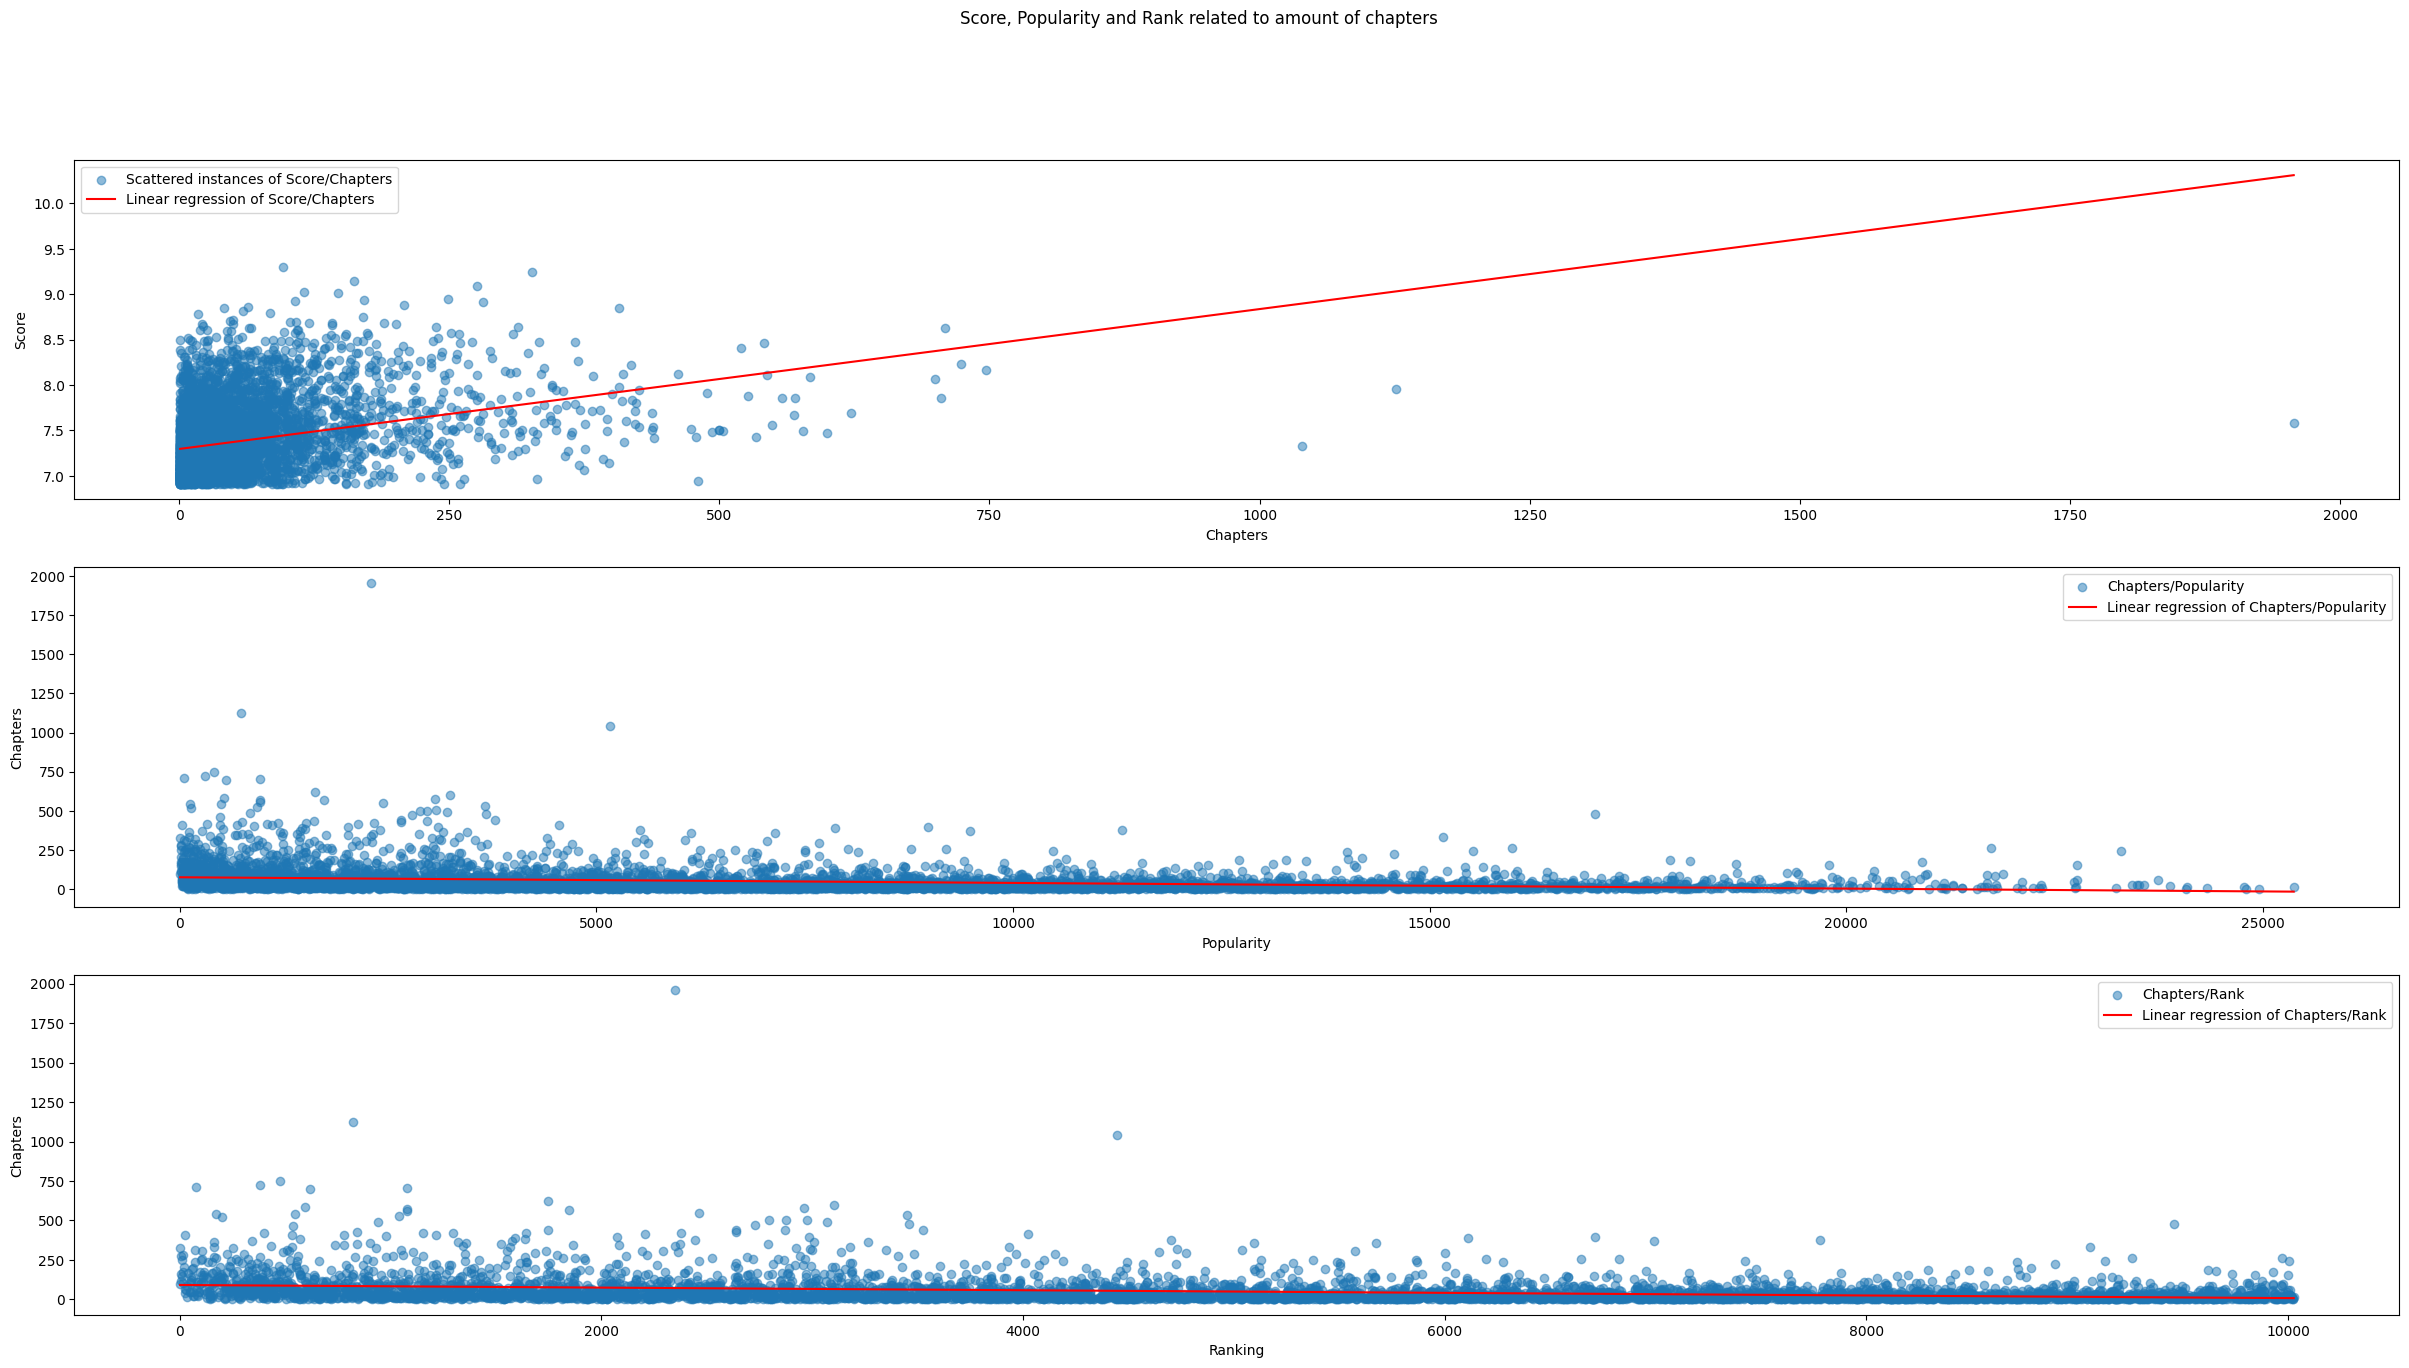

In [33]:
# ----- Plotting metrics against chapters -----
figure, axs = mpl.subplots(3, figsize=(30, 15))
figure.suptitle("Score, Popularity and Rank related to amount of chapters")

# Score-Chapters
score_chap = axs[0].scatter(df.Chapters, df.Score, label="Scattered instances of Score/Chapters", alpha=0.5)
axs[0].set_ylabel("Score")
axs[0].set_xlabel("Chapters")
score_chap_linreg_data = np.polyfit(df.Chapters, df.Score, 1)
xp0 = np.linspace(1, df.Chapters.max())
lr0 = np.polyval(score_chap_linreg_data, xp0)
axs[0].plot(xp0, lr0, color="red", label="Linear regression of Score/Chapters")
axs[0].legend()

# Popularity - Chapters
pop_chap = axs[1].scatter(df.Popularity.sort_values(), df.Chapters, label="Chapters/Popularity", alpha=0.5)
axs[1].set_xlabel("Popularity")
axs[1].set_ylabel("Chapters")
pop_chap_linreg_data = np.polyfit(df.Popularity, df.Chapters, 1)
xp1 = np.linspace(df.Popularity.min(), df.Popularity.max())
lr1 = np.polyval(pop_chap_linreg_data, xp1)
axs[1].plot(xp1, lr1, color="red", label="Linear regression of Chapters/Popularity")
axs[1].legend()

# Ranking - Chapters
rank_chap = axs[2].scatter(df.Ranked.sort_values(), df.Chapters, label="Chapters/Rank", alpha=0.5)
axs[2].set_xlabel("Ranking")
axs[2].set_ylabel("Chapters")
rank_chap_linreg_data = np.polyfit(df.Ranked, df.Chapters, 1)
xp2 = np.linspace(df.Ranked.min(), df.Ranked.max())
lr2 = np.polyval(rank_chap_linreg_data, xp2)
axs[2].plot(xp2, lr2, color="red", label="Linear regression of Chapters/Rank")
axs[2].legend();


We repeat the same procedure, and make the same plots, but for each individual of the 5 most prominent genres. In order for an instance to qualify for a genre it must contain that genre in the genres columnm, but it may still contain other genres.

In [ ]:
# --------- Plot metrics against chapters for each of the genres ---------
for genre in top_genres.index[0:-1]: # Exclude others since its just a count and doesnt exist in the real dataset
    genre_dataset = df[df['Genres'].str.contains(genre, case=False)]

    # ----- Plotting metrics against chapters -----
    figure, axs = mpl.subplots(3, figsize=(30, 15))
    figure.suptitle(genre)

    # Score-Chapters
    score_chap = axs[0].scatter(genre_dataset.Chapters, genre_dataset.Score, label="Scattered instances of Score/Chapters", alpha=0.5)
    axs[0].set_ylabel("Score")
    axs[0].set_xlabel("Chapters")
    score_chap_linreg_data = np.polyfit(genre_dataset.Chapters, genre_dataset.Score, 1)
    xp0 = np.linspace(1, genre_dataset.Chapters.max())
    lr0 = np.polyval(score_chap_linreg_data, xp0)
    axs[0].plot(xp0, lr0, color="red", label="Linear regression of Score/Chapters")
    axs[0].legend()

    # Popularity - Chapters
    pop_chap = axs[1].scatter(genre_dataset.Popularity.sort_values(), genre_dataset.Chapters, label="Chapters/Popularity", alpha=0.5)
    axs[1].set_xlabel("Popularity")
    axs[1].set_ylabel("Chapters")
    pop_chap_linreg_data = np.polyfit(genre_dataset.Popularity, genre_dataset.Chapters, 1)
    xp1 = np.linspace(genre_dataset.Popularity.min(), genre_dataset.Popularity.max())
    lr1 = np.polyval(pop_chap_linreg_data, xp1)
    axs[1].plot(xp1, lr1, color="red", label="Linear regression of Chapters/Popularity")
    axs[1].legend()

    # Ranking - Chapters
    rank_chap = axs[2].scatter(genre_dataset.Ranked.sort_values(), genre_dataset.Chapters, label="Chapters/Rank", alpha=0.5)
    axs[2].set_xlabel("Ranking")
    axs[2].set_ylabel("Chapters")
    rank_chap_linreg_data = np.polyfit(genre_dataset.Ranked, genre_dataset.Chapters, 1)
    xp2 = np.linspace(genre_dataset.Ranked.min(), genre_dataset.Ranked.max())
    lr2 = np.polyval(rank_chap_linreg_data, xp2)
    axs[2].plot(xp2, lr2, color="red", label="Linear regression of Chapters/Rank")
    axs[2].legend()

Examine whether the average score is different for the top genres

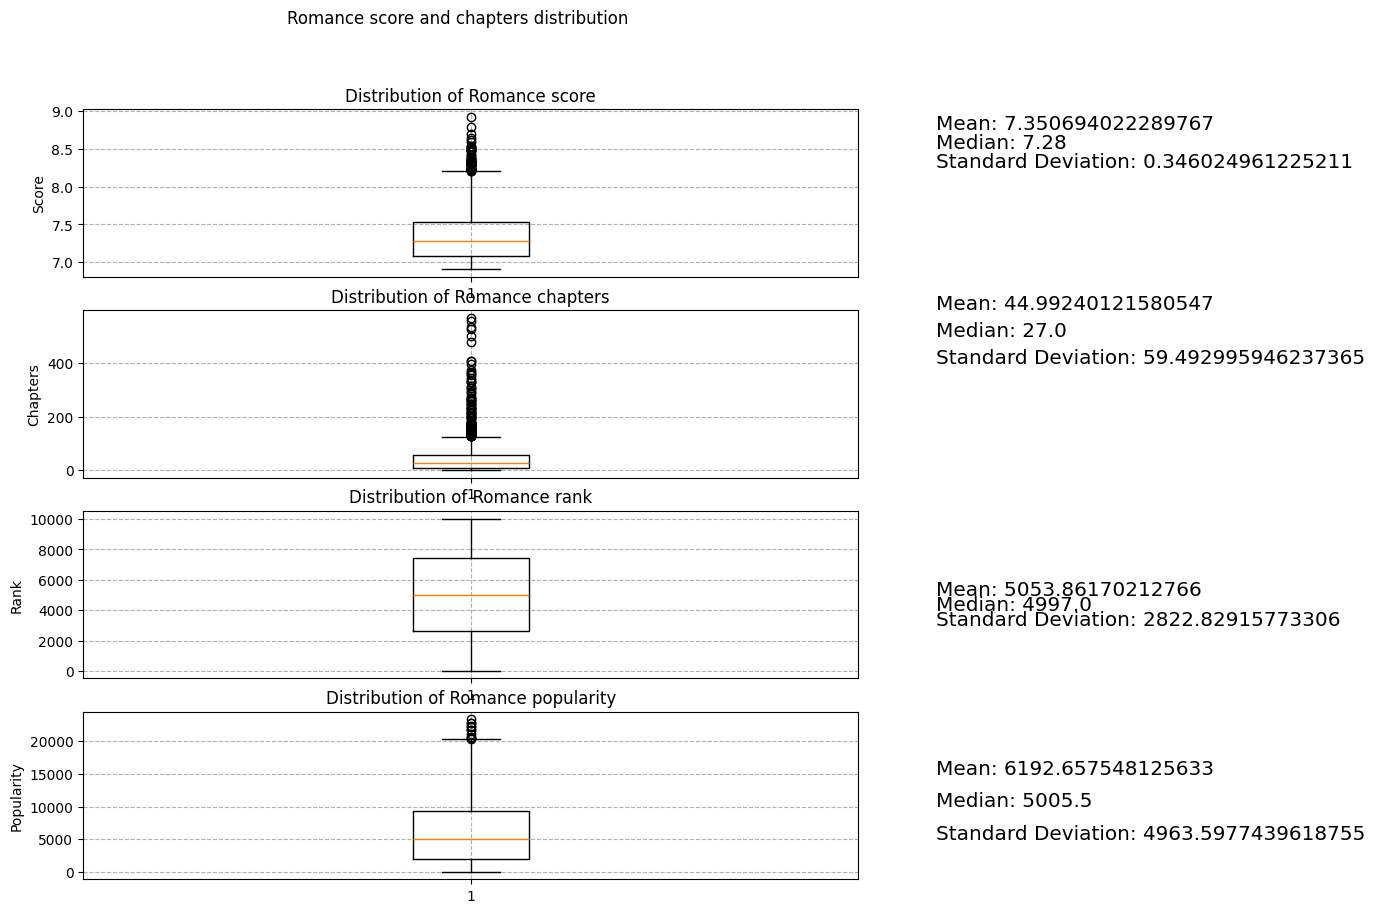

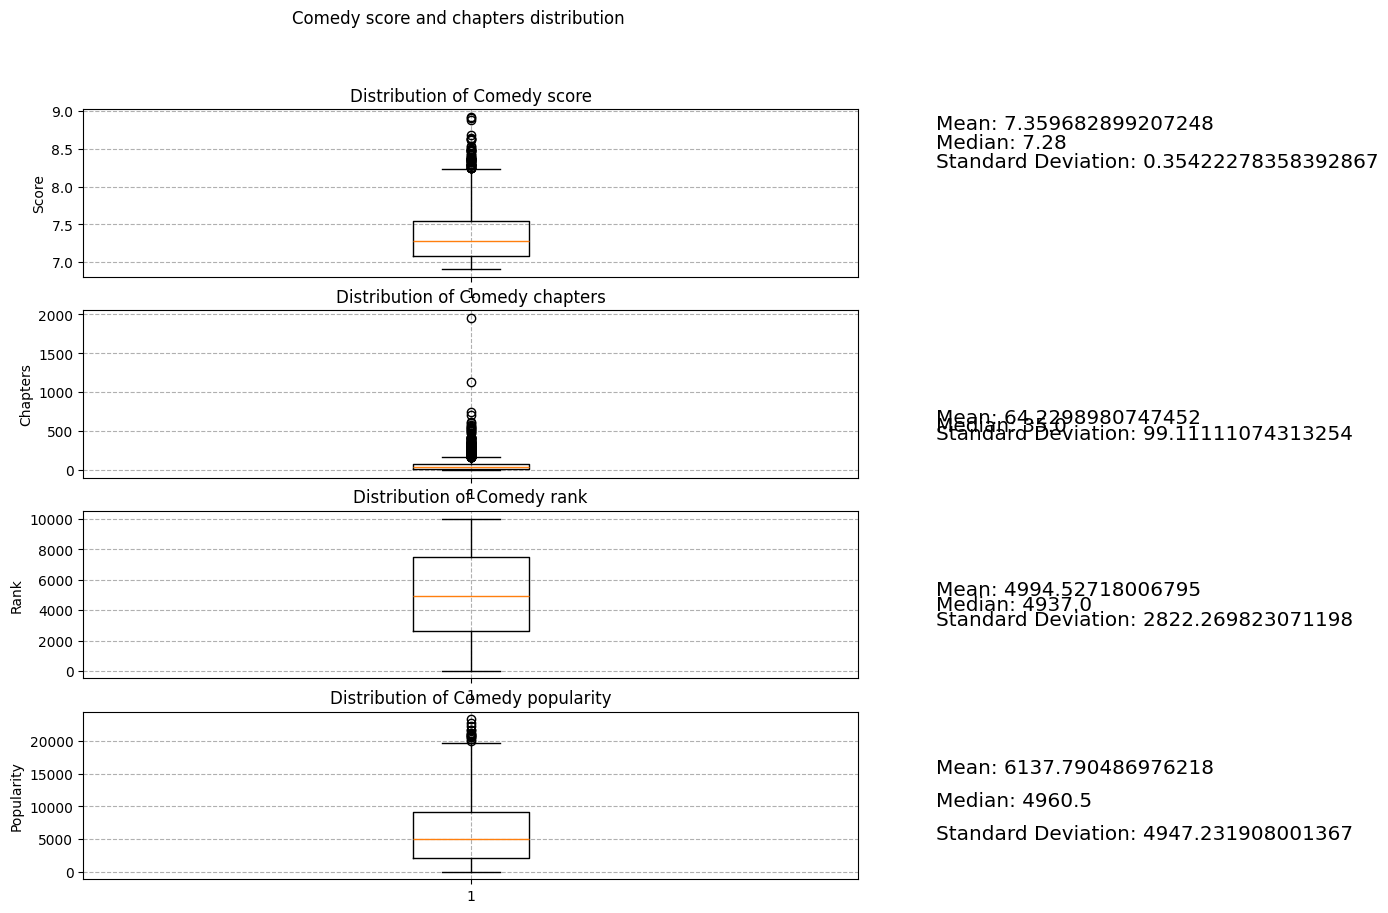

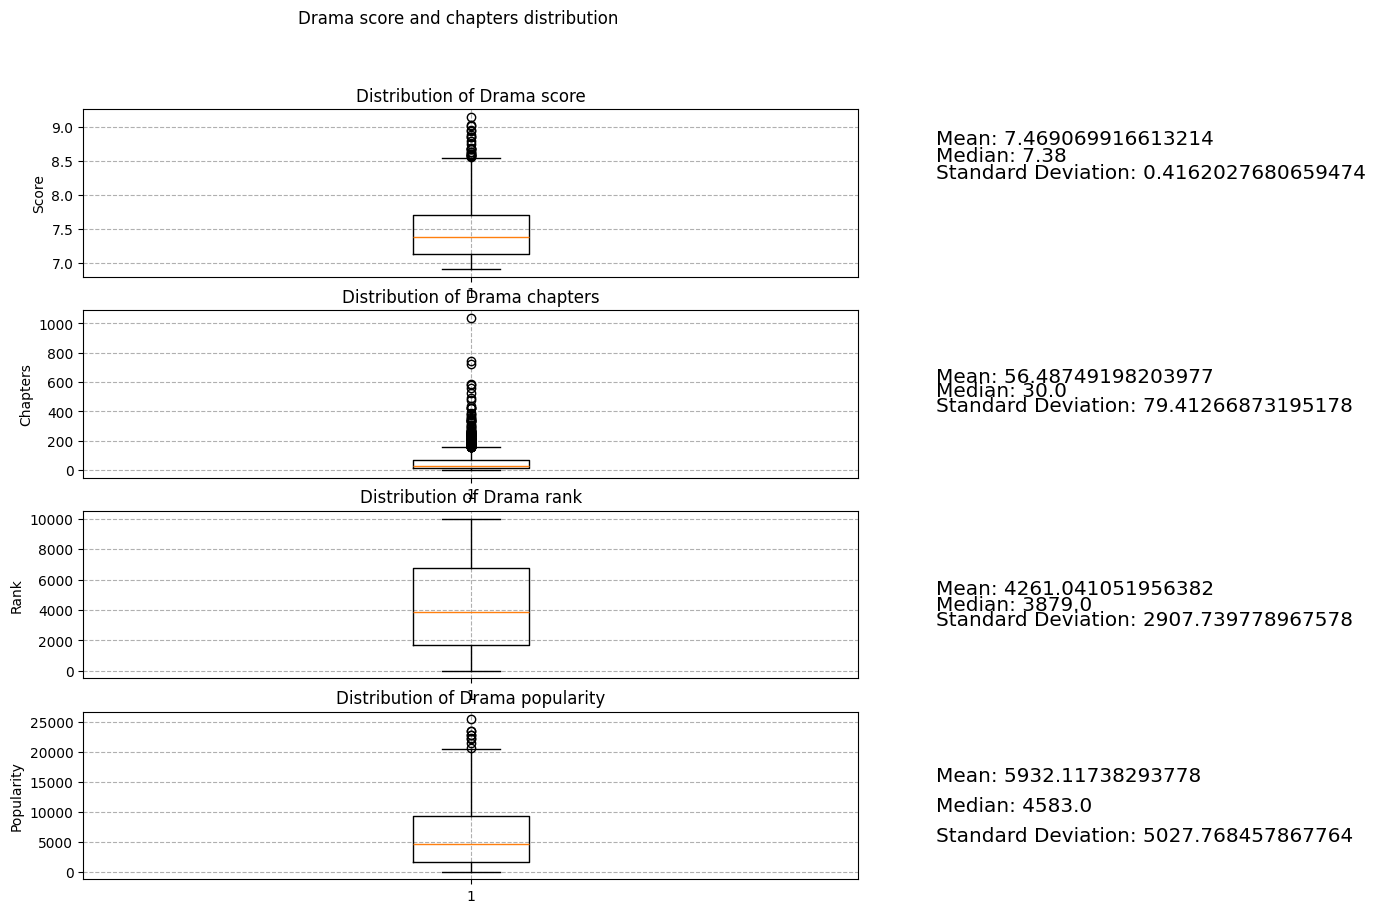

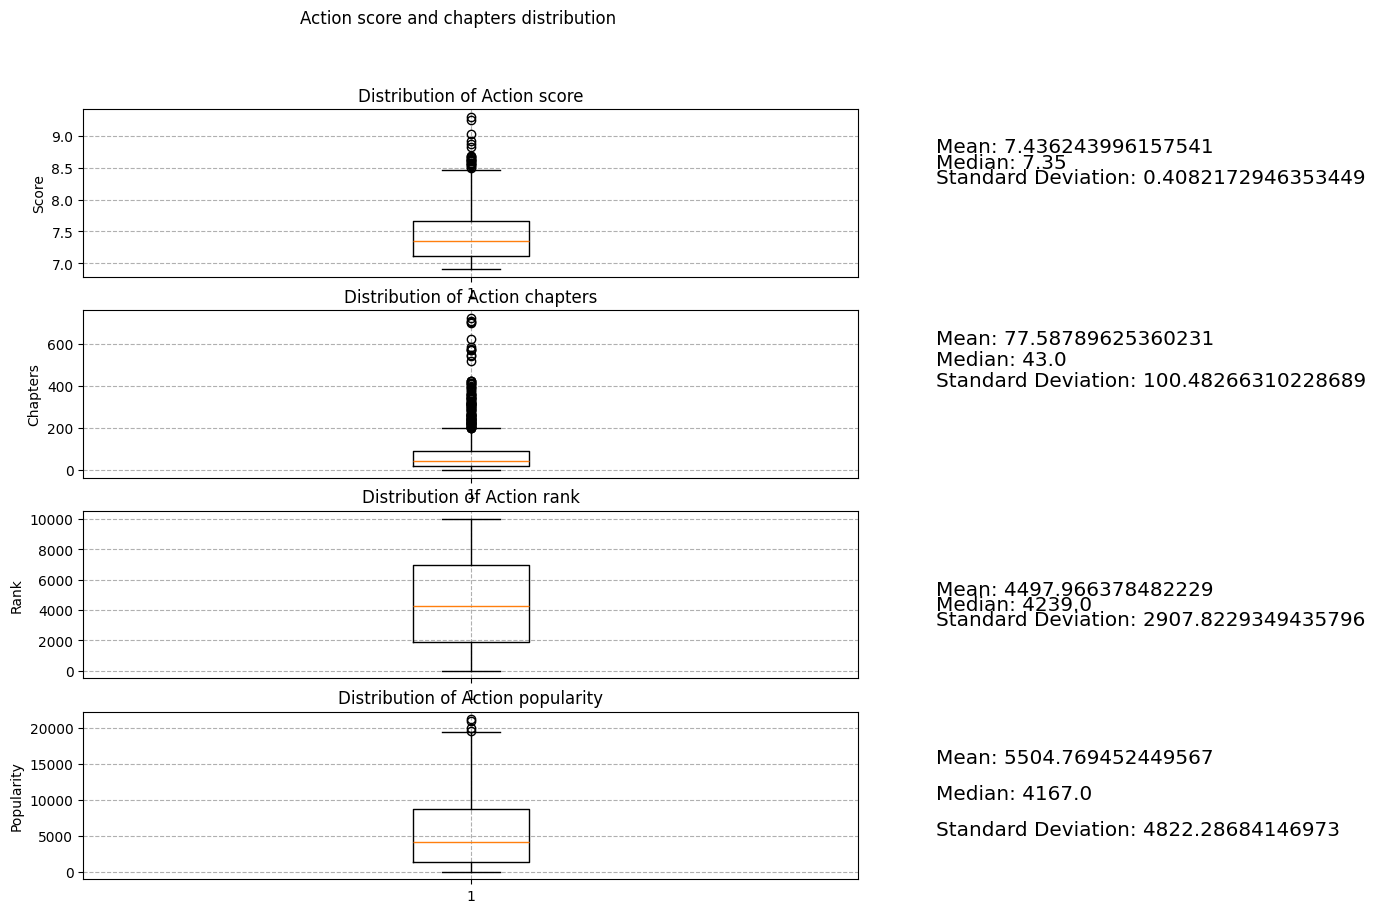

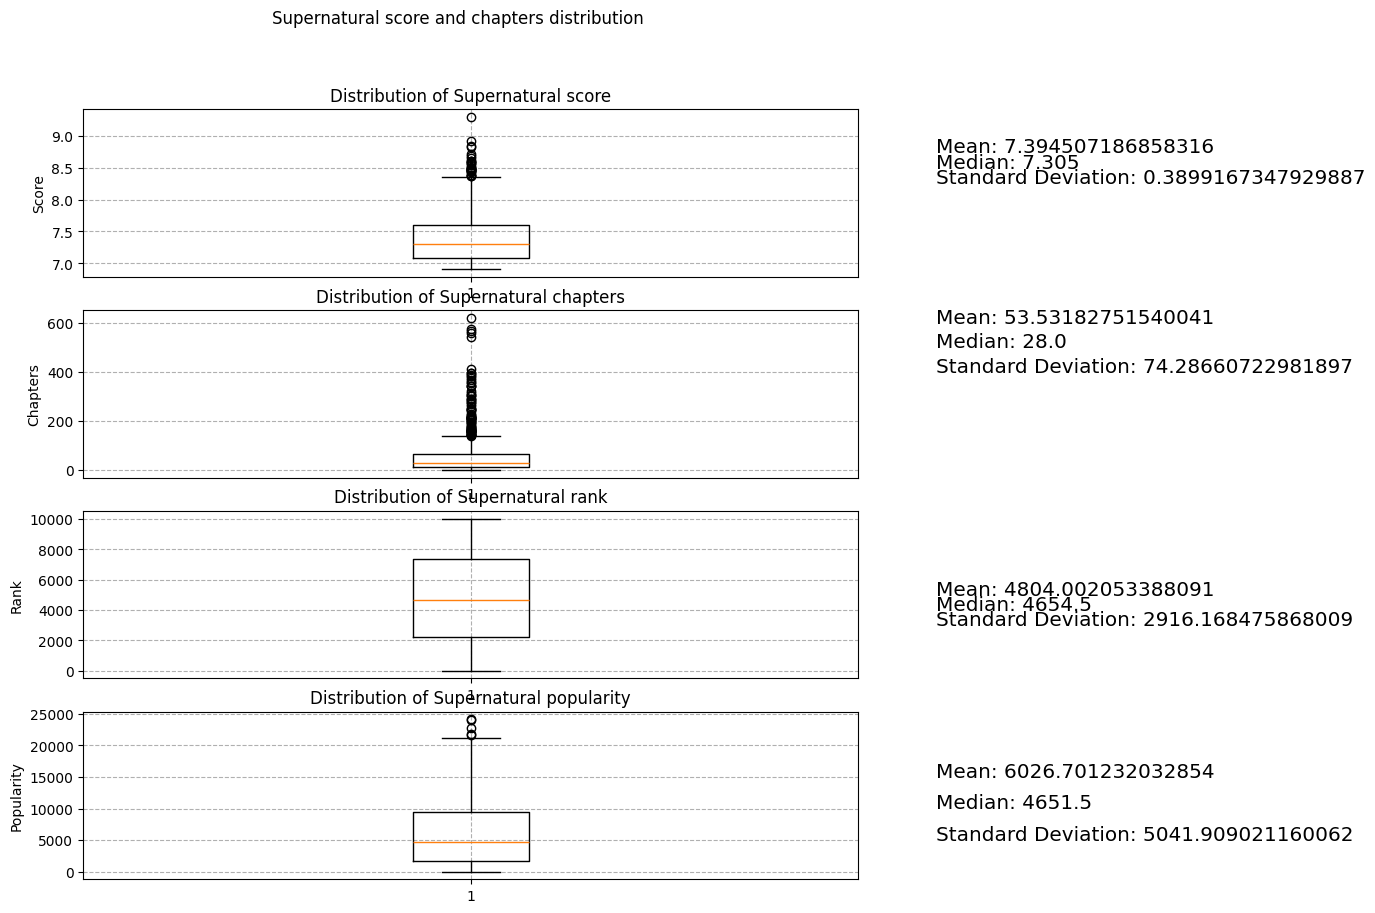

In [40]:
# --------- Examine general differences between genres ---------
# Save means for each genres score and chapter for future use
genre_df_dict = {}

# Plot the general plots for each genre
for genre in top_genres.index[0:-1]: # Exclude others since its just a count and doesnt exist in the real dataset
    
    genre_df = df[df['Genres'].str.contains(genre, case=False)]
    genre_df_dict[genre] = genre_df
    figure, axs = mpl.subplots(4, figsize=(10, 10))
    figure.suptitle(f"{genre} score and chapters distribution")
    
    # Get mean, median and std for score
    mean_score = genre_df.Score.sort_values().mean()
    median_score = genre_df.Score.sort_values().median()
    standard_deviation_score = genre_df.Score.sort_values().std()
    
    # Plot for score
    # axs[0].hist(genre_df.Score, 40, density=True, edgecolor="black")
    axs[0].boxplot(genre_df.Score)
    axs[0].set_title(f"Distribution of {genre} score")
    axs[0].grid(linestyle="--")
    axs[0].set_ylabel("Score")
    axs[0].text(1.6, 8.75, f"Mean: {mean_score}", fontsize="x-large")
    axs[0].text(1.6, 8.5, f"Median: {median_score}", fontsize="x-large")
    axs[0].text(1.6, 8.25, f"Standard Deviation: {standard_deviation_score}", fontsize="x-large")

    # Get mean, median and std for chapters
    mean_chapters = genre_df.Chapters.sort_values().mean()
    median_chapters = genre_df.Chapters.sort_values().median()
    standard_deviation_chapters = genre_df.Chapters.sort_values().std()
    
    # Plot for chapters
    # axs[1].hist(genre_df.Chapters, 400, density=True, color="yellow", edgecolor="black")
    axs[1].boxplot(genre_df.Chapters)
    axs[1].set_title(f"Distribution of {genre} chapters")
    axs[1].grid(linestyle="--")
    axs[1].set_ylabel("Chapters")
    axs[1].text(1.6, 600, f"Mean: {mean_chapters}", fontsize="x-large")
    axs[1].text(1.6, 500, f"Median: {median_chapters}", fontsize="x-large")
    axs[1].text(1.6, 400, f"Standard Deviation: {standard_deviation_chapters}", fontsize="x-large")
    
    #Ranking
    mean_rank = genre_df.Ranked.sort_values().mean()
    median_rank = genre_df.Ranked.sort_values().median()
    standard_deviation_rank = genre_df.Ranked.sort_values().std()
    
    # Plot for chapters
    # axs[1].hist(genre_df.Chapters, 400, density=True, color="yellow", edgecolor="black")
    axs[2].boxplot(genre_df.Ranked)
    axs[2].set_title(f"Distribution of {genre} rank")
    axs[2].grid(linestyle="--")
    axs[2].set_ylabel("Rank")
    axs[2].text(1.6, 5000, f"Mean: {mean_rank}", fontsize="x-large")
    axs[2].text(1.6, 4000, f"Median: {median_rank}", fontsize="x-large")
    axs[2].text(1.6, 3000, f"Standard Deviation: {standard_deviation_rank}", fontsize="x-large")
    
    
    # Popularity
    mean_pop = genre_df.Popularity.sort_values().mean()
    median_pop = genre_df.Popularity.sort_values().median()
    standard_deviation_pop = genre_df.Popularity.sort_values().std()
    
    # Plot for chapters
    # axs[1].hist(genre_df.Chapters, 400, density=True, color="yellow", edgecolor="black")
    axs[3].boxplot(genre_df.Popularity)
    axs[3].set_title(f"Distribution of {genre} popularity")
    axs[3].grid(linestyle="--")
    axs[3].set_ylabel("Popularity")
    axs[3].text(1.6, 15000, f"Mean: {mean_pop}", fontsize="x-large")
    axs[3].text(1.6, 10000, f"Median: {median_pop}", fontsize="x-large")
    axs[3].text(1.6, 5000, f"Standard Deviation: {standard_deviation_pop}", fontsize="x-large")

We also need to test if the hypothesis is true or not. 

In [45]:
# --------- First do ANOVA testing to find any significant variance between genres ---------
print("ANOVA testing for both score and chapters for the different genres")
#First for score
F_value_score, p_value_score = stats.f_oneway(genre_df_dict["Romance"].Score, genre_df_dict["Comedy"].Score, genre_df_dict["Drama"].Score, genre_df_dict["Action"].Score, genre_df_dict["Supernatural"].Score)

print(f"F value for score is {F_value_score}")
print(f"p value for score is {p_value_score}")

alpha = 0.05
if p_value_score > alpha:
    print('Same variance between samples for scores')
else:
    print('Different variance between samples for scores')

print("----------------------------------------")

#Then for chapters
F_value_chap, p_value_chap = stats.f_oneway(genre_df_dict["Romance"].Chapters, genre_df_dict["Comedy"].Chapters, genre_df_dict["Drama"].Chapters, genre_df_dict["Action"].Chapters, genre_df_dict["Supernatural"].Chapters)

print(f"F value for chapters is {F_value_chap}")
print(f"p value for chapters is {p_value_chap}")

alpha = 0.05
if p_value_chap > alpha:
    print('Same variance between samples for chapters')
else:
    print('Different variance between samples for chapters')

print("----------------------------------------")

# Then for Ranking
F_value_rank, p_value_rank = stats.f_oneway(genre_df_dict["Romance"].Ranked, genre_df_dict["Comedy"].Ranked, genre_df_dict["Drama"].Ranked, genre_df_dict["Action"].Ranked, genre_df_dict["Supernatural"].Ranked)

print(f"F value for ranking is {F_value_rank}")
print(f"p value for ranking is {p_value_rank}")

alpha = 0.05
if p_value_rank > alpha:
    print('Same variance between samples for ranking')
else:
    print('Different variance between samples for ranking')

print("----------------------------------------")

# Then for Popularity
F_value_popu, p_value_popu = stats.f_oneway(genre_df_dict["Romance"].Popularity, genre_df_dict["Comedy"].Popularity, genre_df_dict["Drama"].Popularity, genre_df_dict["Action"].Popularity, genre_df_dict["Supernatural"].Popularity)

print(f"F value for popularity is {F_value_popu}")
print(f"p value for popularity is {p_value_popu}")

alpha = 0.05
if p_value_popu > alpha:
    print('Same variance between samples for popularity')
else:
    print('Different variance between samples for popularity')



ANOVA testing for both score and chapters for the different genres
F value for score is 28.55997163167194
p value for score is 1.3889917445807218e-23
Different variance between samples for scores
----------------------------------------
F value for chapters is 30.13360036287981
p value for chapters is 6.606982484221876e-25
Different variance between samples for chapters
----------------------------------------
F value for ranking is 22.195294664378522
p value for ranking is 3.086013166735511e-18
Different variance between samples for ranking
----------------------------------------
F value for popularity is 3.752444490815435
p value for popularity is 0.004708610716162392
Different variance between samples for popularity


When anova is done and any significant variance is determined (there is a significant variance between genres) we must proceed with further apporpriate tests. Since ANOVA failed we cannot do a parametric test.

In [31]:
# --------- Further tests (change this text) ---------

statz, p_val = stats.kruskal(genre_df_dict["Romance"].Score, genre_df_dict["Comedy"].Score, genre_df_dict["Drama"].Score, genre_df_dict["Action"].Score, genre_df_dict["Supernatural"].Score)

print(statz)
print(p_val)

alpha = 0.05
if p_val > alpha:
    print('There is no statistical significance difference between samples (Accept H0, Reject H1)')
else:
    print('There is a statistical significance difference between samples (Accept H1, Reject H0)')

90.4096884584417
1.077638519064254e-18
There is a statistical significance difference between samples (Accept H1, Reject H0)
